# CAPTER 07 합성곱 신경망(CNN)

### 7.1 전체 구조

지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었고, 이를 **완전연결(전연결)** 이라고 하며, 연결된 계층을 **Affine 계층**이라는 이름으로 구현함. 
- 완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU(혹은 Sigmoid 계층)이 이어짐. 
- Affine-ReLU 조합의 연결이 쌓이는 구조,Affine-Softmax로 이어지는 소프트맥스 계층에서 최종 결과(확률) 출력

CNN은 새로운 합성곱계층과 풀링계층이 추가됨. 
- Conv-ReLU-(Pooling)의 흐름으로 연결됨.
- 출력에 가까운 층에서는 지금까지의 Affine-ReLU 구성을 사용할 수 있으며, 마지막 출력계층에서 Affine-Softmax조합을 그대로 사용

### 7.2 합성곱 계층

#### 완전연결 계층의 문제점

**데이터의 형상이 무시된다**<br>
ex) 이미지 데이터를 완전연결 계층에 입력할때는 3차원(세로/가로/채널(색상)) 데이터를 1차원 데이터로 바꿔줘야함. <br>
완전 연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없음

**합성곱 계층은 형상을 유지한다**<br>
이미지처럼 형상을 가진 데이터도 제대로 이해할 수 있음

#### 패딩

- 합성곱 연산을 수행하기 전 입력 데이터 주변을 특정값(ex.0)으로 채우는 작업
- 출력 크기를 조정할 목적으로 사용
- 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달하는 방법

#### 스트라이드

- 필터에 적용하는 위치의 간격

입력 크기를 (H,W), 필터 크기를 (FH,FW), 출력 크기를 (OH,OW), 패딩을 P, 스트라이드를 S라 하면 출력 크기는 다음 식으로 계산

OH = (H+2P-FH)/S +1

OW = (W+2P-FW)/S +1


#### 3차원 데이터의 합성곱 연산

입력 데이터의 채널 수와 필터의 채널 수가 같아야 함을 주의


#### 배치 처리
![batch image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile1.uf.tistory.com%2Fimage%2F99E4C84E5C4D31B7280942)


### 7.3 풀링 계층

풀링은 세로/가로 방향의 공간을 줄이는 연산<br>
최대 풀링, 평균 풀링 등의 방법이 있음<br>
![python image2](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile23.uf.tistory.com%2Fimage%2F99A50F395AAD46301BE8C1)

#### 풀링 계층의 특징

1. **학습해야 할 매개변수가 없음**
2. **채널 수가 변하지 않음**
3. **입력의 변화에 영향을 적게 받음**



### 7.4 합성 곱/ 풀링 계층 구현하기

#### im2col


<img src="https://blog.kakaocdn.net/dn/5a4T2/btqGvQi5TOO/O52OKATjFmFqnzNBKyJtvK/img.png"  width="400" height="200">


![im2col_2.png](https://blog.kakaocdn.net/dn/7QTDk/btqQmOWfPXc/AFhJWTYhSFIVuslykBvpg0/img.png)

#### 합성곱 계층 구현하기

In [3]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

####  풀링 계층 구현하기

다음의 세단계로 진행
1. 입력 데이터를 전개한다
2. 행별 최댓값을 구한다
3. 적절한 모양으로 성형한다

In [5]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 7.5 CNN 구현하기

In [7]:
import sys, os
sys.path.append("C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-master")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [9]:
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")


train loss:2.2991201185697814
=== epoch:1, train acc:0.258, test acc:0.281 ===
train loss:2.296271453140716
train loss:2.2908352497947146
train loss:2.2856821197858235
train loss:2.275070933430098
train loss:2.258414648421277
train loss:2.2443344045237295
train loss:2.22329914280903
train loss:2.195714760165943
train loss:2.1359716584985717
train loss:2.1312564572384334
train loss:2.088970088558379
train loss:2.0290442900956056
train loss:2.0246334248785764
train loss:1.9245283771049706
train loss:1.8230658701828155
train loss:1.8070708627185632
train loss:1.684438088636148
train loss:1.6133453210922641
train loss:1.5995651497350707
train loss:1.5581410693192148
train loss:1.4136803366709998
train loss:1.323693697400723
train loss:1.3384338487119183
train loss:1.3107193042868883
train loss:1.1914065829635836
train loss:1.1463547687041067
train loss:0.9203726975492547
train loss:0.9307846661914501
train loss:1.0217390427316588
train loss:0.8331217268513474
train loss:0.9120374658976135


train loss:0.21604050231537028
train loss:0.1974705273427285
train loss:0.2845026032692654
train loss:0.34526832320634776
train loss:0.17204204403102769
train loss:0.3349357760845455
train loss:0.40779324744013334
train loss:0.29552876118058796
train loss:0.4909131572130825
train loss:0.2161559255387894
train loss:0.26293670367684674
train loss:0.14219785223028883
train loss:0.19511564552519028
train loss:0.24756400631735115
train loss:0.2334041770226391
train loss:0.13184171271784695
train loss:0.24433299993696886
train loss:0.29606561093236133
train loss:0.2982190656373017
train loss:0.3117622030697369
train loss:0.38870850519995814
train loss:0.26087342210387127
train loss:0.2202614802244915
train loss:0.2522553141727874
train loss:0.3126936278374703
train loss:0.20451794509526433
train loss:0.35305957710271235
train loss:0.3066428593243551
train loss:0.3396336691417892
train loss:0.17198924007190286
train loss:0.18298461392295484
train loss:0.21197055015381708
train loss:0.20510909

train loss:0.0717087041566315
train loss:0.17574889275890498
train loss:0.17421935727661852
train loss:0.07453646384104426
train loss:0.14905869274254527
train loss:0.1621182830397979
train loss:0.1111491262792804
train loss:0.07495379394760862
train loss:0.1665510606251175
train loss:0.19184616629096804
train loss:0.11881647104054492
train loss:0.14543806337708676
train loss:0.1472646397671361
train loss:0.17513141738509932
train loss:0.25910532747217
train loss:0.21504025039277092
train loss:0.16311443747591217
train loss:0.20922131622063206
train loss:0.16709329486700297
train loss:0.1460988154093952
train loss:0.17565235384436398
train loss:0.16217512538627854
train loss:0.09986358808874878
train loss:0.0948818095222265
train loss:0.15762859391263306
train loss:0.19245245886419313
train loss:0.13145422151545036
train loss:0.33400131862994953
train loss:0.3331172544848146
train loss:0.11286903286175848
train loss:0.16828149044855056
train loss:0.09130247805976946
train loss:0.058472

train loss:0.07161281053104213
train loss:0.09781888115758526
train loss:0.15628678493505574
train loss:0.12919406942800218
train loss:0.05898546890029495
train loss:0.17527428861811908
train loss:0.10336700022203338
train loss:0.10393147238948015
train loss:0.12772266938482157
train loss:0.07664144249830102
train loss:0.10280311802896065
train loss:0.24172364530896842
train loss:0.07226783356682369
train loss:0.07777152417590724
train loss:0.09108406912562268
train loss:0.1809761483774961
train loss:0.17885624279802928
train loss:0.11842766538573983
train loss:0.17273808496232376
train loss:0.06761560693001688
train loss:0.10801578047446114
train loss:0.09344202902258149
train loss:0.1338894678344843
train loss:0.1544959410988396
train loss:0.15565426866688076
train loss:0.11233239211806412
train loss:0.16255682638646668
train loss:0.09728202488028803
train loss:0.08790301327015747
train loss:0.10964404344637453
train loss:0.18719765292049903
train loss:0.1017030969030897
train loss:0

train loss:0.07450065978822255
train loss:0.043524274493729954
train loss:0.035477760047197576
train loss:0.06763234479701519
train loss:0.03284047008170321
train loss:0.09508351420386417
train loss:0.10374441629448741
train loss:0.05380861801099192
train loss:0.0961919956410482
train loss:0.0911734173353369
train loss:0.04114851610974798
train loss:0.04990559961480339
train loss:0.05890058202209045
train loss:0.0680889603966964
train loss:0.09783887694955283
train loss:0.10735596533123996
train loss:0.046293564537870854
train loss:0.06906533892013322
train loss:0.13612544404665944
train loss:0.05567186045032451
train loss:0.0399570117291905
train loss:0.011431861915002409
train loss:0.07917107161190334
train loss:0.11047063299569818
train loss:0.1441320724641461
train loss:0.12408418380994457
train loss:0.09084549688763198
train loss:0.030950872643529168
train loss:0.057504138969016266
train loss:0.019666420640414614
train loss:0.21007351211154543
train loss:0.0583201162280148
train l

train loss:0.034955959689938504
train loss:0.12995053845552185
train loss:0.1343442322127417
train loss:0.09065934804543574
train loss:0.037647109040538335
train loss:0.05728921085857913
train loss:0.023521269005018944
train loss:0.08132487455491855
train loss:0.056474283733987864
train loss:0.08629643444639118
train loss:0.1235344914892711
train loss:0.09473932867064376
train loss:0.11750354495337609
train loss:0.1104959162329243
train loss:0.055134696086127505
train loss:0.06073376869129198
train loss:0.09081643097580909
train loss:0.113748612372065
train loss:0.11318935562341811
train loss:0.03243845787928303
train loss:0.040607096076337716
train loss:0.06796263195535873
train loss:0.07340832242370085
train loss:0.08346091862697723
train loss:0.1015412480312074
train loss:0.07005412178023472
train loss:0.02135728555241559
train loss:0.06691358587124893
train loss:0.06252385561101775
train loss:0.021054624910258286
train loss:0.04085202440102483
train loss:0.09741856288708572
train l

train loss:0.05744910224814518
train loss:0.039934553467432535
train loss:0.06332254474033341
train loss:0.0801194707528161
train loss:0.034650936998780975
train loss:0.08619861946008714
train loss:0.1064724177395673
train loss:0.03347772839860843
train loss:0.05071750765433256
train loss:0.0567470511144649
train loss:0.05209722962349668
train loss:0.03597478291346214
train loss:0.15058327342240838
train loss:0.02846728950882825
train loss:0.04014084978621382
train loss:0.03268094895975926
train loss:0.02905920346325241
train loss:0.05054477890388667
train loss:0.018491747313749547
train loss:0.020754138474838486
train loss:0.025626100295063493
train loss:0.019921620487145752
train loss:0.03655981601000306
train loss:0.114025128037993
train loss:0.07092207878736552
train loss:0.025207580591395825
train loss:0.03576939549812873
train loss:0.06414385368131746
train loss:0.025407892307748252
train loss:0.09606016015272059
train loss:0.04980895921806109
train loss:0.0953530965198601
train 

train loss:0.03392418650991886
train loss:0.03232975390453764
train loss:0.06172426470802025
train loss:0.13706033323630942
train loss:0.0966297786777597
train loss:0.041046379156986834
train loss:0.024203680013567846
train loss:0.02547617745196743
train loss:0.016970932337747963
train loss:0.027341254323572695
train loss:0.029258582469514353
train loss:0.03235206185224343
train loss:0.08762428506519747
train loss:0.07590732971439076
train loss:0.03808336561174817
train loss:0.044702102951580856
train loss:0.053950407242996504
train loss:0.005251756944894619
train loss:0.028097296779565895
train loss:0.01699605277335512
train loss:0.049324832880190336
train loss:0.037649568409307735
train loss:0.050461283452226884
train loss:0.08974161431725448
train loss:0.02443144845539616
train loss:0.024080983519864464
train loss:0.025322336035885854
train loss:0.033800866891192695
train loss:0.032133818650486395
train loss:0.035777917345090136
train loss:0.04354330426957267
train loss:0.1056756775

train loss:0.03897316558672472
train loss:0.03852037858924745
train loss:0.04319623322840609
train loss:0.0961870386408156
train loss:0.07770113239425135
train loss:0.07054385414066078
train loss:0.02072563429628143
train loss:0.06518759783324633
train loss:0.0911875425584692
train loss:0.050234306364357446
train loss:0.06844006596673925
train loss:0.04181533894146124
train loss:0.09109754300827819
train loss:0.0443811300671028
train loss:0.043647442741502236
train loss:0.032410085958152625
train loss:0.01189805369185015
train loss:0.04309466376393096
train loss:0.01736362588463108
train loss:0.019424556330518705
train loss:0.05556785825163766
train loss:0.10296017117840897
train loss:0.014119106805580308
train loss:0.0514422593294043
train loss:0.06362412604530626
train loss:0.026672269931562687
train loss:0.02997203882440223
train loss:0.01901541100269203
train loss:0.040910910226821195
train loss:0.024514903118118832
train loss:0.016878451358097995
train loss:0.1322448991009499
trai

train loss:0.08254920089603049
train loss:0.04254457784945762
train loss:0.029114974379479793
train loss:0.008159005595434542
train loss:0.0074854432452929505
train loss:0.06194064534869752
train loss:0.015497338946533337
train loss:0.014461075899732518
train loss:0.016361410195772103
train loss:0.034516582512119434
train loss:0.007278178669863893
train loss:0.010104825548483944
train loss:0.010835011737536662
train loss:0.021257119215142242
train loss:0.02505981470875356
train loss:0.08282024856072483
train loss:0.018634953939472575
train loss:0.030340309174917895
train loss:0.027327715806845503
train loss:0.037348496514377896
train loss:0.009482620486809666
=== epoch:5, train acc:0.988, test acc:0.98 ===
train loss:0.04992857205406387
train loss:0.025703361427663666
train loss:0.033934465369203276
train loss:0.00789175942169779
train loss:0.058583520928559486
train loss:0.019603292788342188
train loss:0.023889511799194928
train loss:0.011335778470573437
train loss:0.01141424289606784

train loss:0.006047484059036027
train loss:0.007835239430118567
train loss:0.0257471958669736
train loss:0.015922770122043885
train loss:0.01472922240939353
train loss:0.02147935865208651
train loss:0.0069453521944912895
train loss:0.0760659170094021
train loss:0.022726751873543945
train loss:0.01170989912371135
train loss:0.016595968648364975
train loss:0.007448665964023607
train loss:0.011335619706048601
train loss:0.04623019036974876
train loss:0.042215059564338187
train loss:0.023166068926006096
train loss:0.05691518723293151
train loss:0.060166643079172265
train loss:0.023934921772902067
train loss:0.022355516353626648
train loss:0.012658804598304894
train loss:0.016323979425990984
train loss:0.0529552553640332
train loss:0.05940631149944298
train loss:0.04396301865992286
train loss:0.039236325240141506
train loss:0.013956015614806376
train loss:0.013427152026075553
train loss:0.07404877012398031
train loss:0.05051846434312006
train loss:0.006457522726200501
train loss:0.010473138

train loss:0.013891685486025446
train loss:0.009016636545962388
train loss:0.04473315493795105
train loss:0.04904104512005118
train loss:0.02721696143332355
train loss:0.046819730423808714
train loss:0.0338731895081122
train loss:0.0068125253637779
train loss:0.010356979251807402
train loss:0.018081670918018756
train loss:0.027702556551804678
train loss:0.023434254887102948
train loss:0.053221493707245694
train loss:0.009258096167548944
train loss:0.010593451073055744
train loss:0.03164501488749004
train loss:0.04959000319214463
train loss:0.021236824734086068
train loss:0.015812085337794875
train loss:0.010521515955205006
train loss:0.062354456682819304
train loss:0.010391859928696724
train loss:0.030359906223499145
train loss:0.009805139869335299
train loss:0.04894799778845198
train loss:0.030479255240491512
train loss:0.058772344784832446
train loss:0.05816143613349447
train loss:0.05074213061880736
train loss:0.05497121613318536
train loss:0.027084490941280574
train loss:0.03772899

train loss:0.017541774646367487
train loss:0.029780289610987408
train loss:0.009097301081514308
train loss:0.018716476759758408
train loss:0.009240344314199745
train loss:0.012004185044422539
train loss:0.014386161495836935
train loss:0.022941285406349068
train loss:0.01984815239239969
train loss:0.014578673817231245
train loss:0.0072744393050189786
train loss:0.011904914499885191
train loss:0.021478677234914114
train loss:0.02583285985550782
train loss:0.011881845602151293
train loss:0.04445999088680469
train loss:0.010882314777778153
train loss:0.02038076570577227
train loss:0.02664924981449742
train loss:0.004798221190067962
train loss:0.016612217453433758
train loss:0.008278810656081655
train loss:0.009556068474694725
train loss:0.018191465605975673
train loss:0.019228372881935855
train loss:0.023778603210269943
train loss:0.028387750209681456
train loss:0.05373147142488072
train loss:0.025669615140205496
train loss:0.02540741614553269
train loss:0.012041756779700373
train loss:0.0

train loss:0.028835843835986644
train loss:0.0173609826218396
train loss:0.0034924246286126242
train loss:0.028887868483371403
train loss:0.02488855623915929
train loss:0.008796153194780072
train loss:0.0092332618644677
train loss:0.011671942473746717
train loss:0.009772040488301777
train loss:0.011106865193281842
train loss:0.009393391517261394
train loss:0.019071781391833444
train loss:0.006651983387716904
train loss:0.013748286680163273
train loss:0.044800347970380405
train loss:0.009688379719683561
train loss:0.01857316015232871
train loss:0.020530235520531882
train loss:0.005408241409767458
train loss:0.009150963644233517
train loss:0.0065658613668264565
train loss:0.002686405284078172
train loss:0.0298529855616594
train loss:0.04976425421122893
train loss:0.00867150676800301
train loss:0.008396869627610212
train loss:0.01821307578025755
train loss:0.05640487595679314
train loss:0.0366668629436079
train loss:0.010953361322430431
train loss:0.026966924542379988
train loss:0.0513609

train loss:0.002327622265618381
train loss:0.017872309521241372
train loss:0.04295036139303025
train loss:0.00541173841953541
train loss:0.018484442456426754
train loss:0.011796213021757911
train loss:0.046299060897714475
train loss:0.021854417313455388
train loss:0.011250534578262122
train loss:0.04388270555240378
train loss:0.06539264401029027
train loss:0.015310241659718565
train loss:0.00657514183490549
train loss:0.188790608626301
train loss:0.0019163998307681835
train loss:0.010248154726075424
train loss:0.009856463348912605
train loss:0.06249335573507293
train loss:0.049752010869672986
train loss:0.013603166026100679
train loss:0.017576833567231786
train loss:0.012821515220860613
train loss:0.002963079730782835
train loss:0.014244381459641747
train loss:0.005627349631290047
train loss:0.009519176722343507
train loss:0.012280327032169918
train loss:0.007147316784637829
train loss:0.028099600583759363
train loss:0.006662998177731278
train loss:0.0038019157406153285
train loss:0.02

train loss:0.027291997518859103
train loss:0.016036648235791998
train loss:0.06464606770420424
train loss:0.013278390923651018
train loss:0.009517086930734844
train loss:0.026420114735655115
train loss:0.004566194616021572
train loss:0.024099110990508585
train loss:0.006914746736180226
train loss:0.02267563148180612
train loss:0.0037971214175560298
train loss:0.017340240546661573
train loss:0.012076762806659662
train loss:0.0006933932854539264
train loss:0.020356868663518775
train loss:0.007335268195274294
train loss:0.009586062035364253
train loss:0.011890813782103422
train loss:0.006175738943815947
train loss:0.0117901295393258
train loss:0.014856390315990602
train loss:0.012669070268883142
train loss:0.007603026743158061
train loss:0.002456677558529301
train loss:0.016984006632400513
train loss:0.022264265220853785
train loss:0.026571156467064934
train loss:0.00508644689551758
train loss:0.00518472699583078
train loss:0.044838096926177434
train loss:0.0071858494451859855
train loss:

train loss:0.013182664019131995
train loss:0.04278195681832048
train loss:0.016085939702129223
train loss:0.004070813127851925
train loss:0.005735970213598004
train loss:0.032184338774875934
train loss:0.009165978147298389
train loss:0.043303850370727426
train loss:0.0670552840389796
train loss:0.005507917796688125
train loss:0.021814405360287826
train loss:0.01773905624433711
=== epoch:8, train acc:0.993, test acc:0.983 ===
train loss:0.01235304459253493
train loss:0.006095411355283837
train loss:0.005986125279169519
train loss:0.011541127445045263
train loss:0.0015224086793332481
train loss:0.024487926582246966
train loss:0.013372959405474106
train loss:0.012180383603248364
train loss:0.00949995894403191
train loss:0.009571831914382673
train loss:0.0030556366772656967
train loss:0.036839956050231104
train loss:0.031163015134830222
train loss:0.06554441639173074
train loss:0.008138155907797895
train loss:0.011608104671682284
train loss:0.005683662902053249
train loss:0.003692253654196

train loss:0.012496449197134336
train loss:0.048832155872028264
train loss:0.03318647849520163
train loss:0.022770618068413982
train loss:0.007151655587148423
train loss:0.016506510393213866
train loss:0.031161600188186776
train loss:0.02670567110997616
train loss:0.016854399852977774
train loss:0.008995544734770058
train loss:0.035279691469055505
train loss:0.01161508487580134
train loss:0.023407028597354235
train loss:0.048752390483738264
train loss:0.00647421877464592
train loss:0.016981412349533577
train loss:0.005301177264402422
train loss:0.018126796320863444
train loss:0.01943500142806955
train loss:0.004383338311786582
train loss:0.02586347001031347
train loss:0.0064006672628298625
train loss:0.01163127716463596
train loss:0.03296566962684591
train loss:0.03010500687689885
train loss:0.007172512793605574
train loss:0.0062253772705926115
train loss:0.007184714315145248
train loss:0.019202895660494587
train loss:0.022915830031456856
train loss:0.0019263099140056927
train loss:0.0

train loss:0.011708643293552921
train loss:0.016292014117165438
train loss:0.006391175378129242
train loss:0.007083667401646925
train loss:0.044124183299327005
train loss:0.004831730950112067
train loss:0.009485164727087426
train loss:0.00816717116372019
train loss:0.007535022564862127
train loss:0.0348338760555533
train loss:0.0033275644969887686
train loss:0.034285151417500874
train loss:0.06594026419671326
train loss:0.0019375568509376806
train loss:0.004638683745625711
train loss:0.009749885167949578
train loss:0.0029892833276866115
train loss:0.002975150196695411
train loss:0.005329944427735456
train loss:0.010880394169193255
train loss:0.008075629159003912
train loss:0.0357639959275072
train loss:0.00459709366873941
train loss:0.017403173110359573
train loss:0.00787248034381052
train loss:0.03126372063443595
train loss:0.026514960054942683
train loss:0.0051821833025245505
train loss:0.03294183942912345
train loss:0.02618281108987308
train loss:0.012634870087146595
train loss:0.01

train loss:0.01756486470756117
train loss:0.005006617498433616
train loss:0.0052836946872498545
train loss:0.008146395099905083
train loss:0.01583120008096321
train loss:0.004601851335032297
train loss:0.03123911053069982
train loss:0.022746772173843906
train loss:0.017523753353900773
train loss:0.013187342508923137
train loss:0.0013109213376699509
train loss:0.005766064637663515
train loss:0.0043160322396008175
train loss:0.027121253417954752
train loss:0.01745683498232009
train loss:0.005096604701420707
train loss:0.016923427554438063
train loss:0.007337487608681854
train loss:0.021272209089204717
train loss:0.005257091338329278
train loss:0.00846427543148758
train loss:0.001863208258608963
train loss:0.009239309519049698
train loss:0.015008298908276874
train loss:0.012624283656316036
train loss:0.018534085682878607
train loss:0.006601853896750261
train loss:0.0032926539410729778
train loss:0.003047048877971195
train loss:0.007421756634768279
train loss:0.0047003795806716524
train lo

train loss:0.024688085973129926
train loss:0.0014334771841851652
train loss:0.00213102753044778
train loss:0.01981741126122998
train loss:0.005484204736814702
train loss:0.0051898647613642865
train loss:0.026455964659344695
train loss:0.007758951198410147
train loss:0.009931649964686158
train loss:0.003974279140055686
train loss:0.013112020655812691
train loss:0.015662199093384666
train loss:0.010169392394372735
train loss:0.024362141668012795
train loss:0.01954137302592074
train loss:0.005555629461310464
train loss:0.016023527384657323
train loss:0.08747586861711579
train loss:0.0017362998018003856
train loss:0.05833436628904919
train loss:0.010635296841683335
train loss:0.013684438587929913
train loss:0.006489059353942107
train loss:0.008253546354928514
train loss:0.007353746414615321
train loss:0.004997535626579541
train loss:0.005701837390910458
train loss:0.012286429001112785
train loss:0.021216281745307958
train loss:0.009506959636893481
train loss:0.014056694267018659
train loss

train loss:0.010682202583514246
train loss:0.007952436722598424
train loss:0.022655633723672672
train loss:0.008838415309522885
train loss:0.0033010860904292495
train loss:0.017808111188763638
train loss:0.0064807020014362145
train loss:0.00166144792556219
train loss:0.011120743995351921
train loss:0.018810643976342575
train loss:0.00954589720587288
train loss:0.004892474755250129
train loss:0.01411481407140505
train loss:0.013423894085614712
train loss:0.004571410730947839
train loss:0.012994847074449416
train loss:0.0016268153300951105
train loss:0.006832290324066888
train loss:0.0084590889717764
train loss:0.00993438831896831
train loss:0.023827708123399658
train loss:0.005078032793374591
train loss:0.0413263902426936
train loss:0.002201056605355974
train loss:0.003862387610493334
train loss:0.011502168090091268
train loss:0.001961562145226864
train loss:0.004575985066622806
train loss:0.01328439927013271
train loss:0.0032152179060466178
train loss:0.0017371474979908966
train loss:0

train loss:0.006776026881342082
train loss:0.01595283109338304
train loss:0.002269693461815732
train loss:0.03282712807336368
train loss:0.008856650672719967
train loss:0.006537914753301621
train loss:0.004386045151593832
train loss:0.004005219505985278
train loss:0.010422023049601395
train loss:0.005089945187622882
train loss:0.009806767873939587
train loss:0.04474075456524373
train loss:0.00046570765373730674
train loss:0.00877909224817281
train loss:0.0035959438591547156
train loss:0.007742407888096787
train loss:0.003175617746203746
train loss:0.009199466622642446
train loss:0.0044418707802359346
train loss:0.024650110778717607
train loss:0.011780232044160182
train loss:0.00807284386543199
train loss:0.020078154993179664
train loss:0.00832935490849265
train loss:0.003355057768268497
train loss:0.004512944746339757
train loss:0.0013718981554200708
train loss:0.0005725293824222653
train loss:0.004039514635406141
train loss:0.0010082003956699425
train loss:0.07879412612916278
train lo

train loss:0.01778492397244966
train loss:0.007313010712798718
train loss:0.0038773291012157694
train loss:0.010528646283399416
train loss:0.009789736398357684
train loss:0.003609042212012488
train loss:0.0027315432438684744
train loss:0.004195960008834532
train loss:0.011227233487233559
train loss:0.004668714256066822
train loss:0.019949983234275197
train loss:0.0015550798639647877
train loss:0.005443783205831029
train loss:0.013992550585418668
train loss:0.014251209735408756
train loss:0.01749481799679987
train loss:0.0027023321080340418
train loss:0.006207786049010103
train loss:0.010692632655409312
train loss:0.007385422482980953
=== epoch:11, train acc:0.995, test acc:0.985 ===
train loss:0.0048126460555659115
train loss:0.01276113854119541
train loss:0.0034591947497029313
train loss:0.012849253134960326
train loss:0.004332049670636353
train loss:0.04600622170877818
train loss:0.009442724666644559
train loss:0.003554363219049373
train loss:0.0013845043424451809
train loss:0.006746

train loss:0.010659186574770853
train loss:0.002018204131067151
train loss:0.008810226317816826
train loss:0.011318979415701352
train loss:0.006757274663127401
train loss:0.0025898953400191275
train loss:0.0023476190939191004
train loss:0.003631830646146322
train loss:0.02576838030795819
train loss:0.03227959195899302
train loss:0.004611438810479509
train loss:0.024066470056571938
train loss:0.014292902024814891
train loss:0.005327208765633256
train loss:0.007733926993539264
train loss:0.0030271791025016574
train loss:0.0028853984867785983
train loss:0.0012046005766067087
train loss:0.005742095449523548
train loss:0.0056121064198443515
train loss:0.018312010561375124
train loss:0.004255560079106635
train loss:0.014566678151322277
train loss:0.01257532424127707
train loss:0.04689780133818837
train loss:0.04667620648018222
train loss:0.004855474405903544
train loss:0.0006391369595997229
train loss:0.0005360446172321432
train loss:0.005221321187768915
train loss:0.007666129658291447
train

train loss:0.006421892760137714
train loss:0.0048762263796121395
train loss:0.0010571592826365821
train loss:0.00357870759957059
train loss:0.004132877640406958
train loss:0.005821598775944174
train loss:0.0021376354002508673
train loss:0.0044623348224562005
train loss:0.0059835171387063145
train loss:0.002239742903019091
train loss:0.0019017460333642842
train loss:0.006881770660116345
train loss:0.004484772832089248
train loss:0.01799139631102744
train loss:0.0181517769221502
train loss:0.005779891801859772
train loss:0.004549508405922332
train loss:0.015326654976731396
train loss:0.0008412526248344805
train loss:0.009472136074742848
train loss:0.0494206599708446
train loss:0.009724879059547857
train loss:0.029158611081433868
train loss:0.00810876304813672
train loss:0.09930961130098043
train loss:0.001153167629419441
train loss:0.0008847126774970329
train loss:0.0019034595403094171
train loss:0.011990123313080678
train loss:0.004734606391212171
train loss:0.00597351788663653
train lo

train loss:0.00800862473594315
train loss:0.00970440168134008
train loss:0.0022177695970243853
train loss:0.001036302435271295
train loss:0.03934434657883955
train loss:0.0003408860276111981
train loss:0.0057054874440769935
train loss:0.006897822264815372
train loss:0.0026319936039842073
train loss:0.0007031474645516989
train loss:0.002214649904942745
train loss:0.010241227767147318
train loss:0.0014286148870343127
train loss:0.001567397016737303
train loss:0.008609990937622356
train loss:0.0028256916451738856
train loss:0.005671899049618702
train loss:0.004267006074365023
train loss:0.004127934097840178
train loss:0.0039057530540683766
train loss:0.0007390723114820215
train loss:0.001896276593476633
train loss:0.008405383098241298
train loss:0.00026895284286291573
train loss:0.002214655244682833
train loss:0.004831514597433978
train loss:0.02577608727664079
train loss:0.004423625567097357
train loss:0.001036679364489971
train loss:0.000685529323879759
train loss:0.008730648680331483
t

train loss:0.0373437556294229
train loss:0.0018448529271679096
train loss:0.001661722481295565
train loss:0.010747680921263304
train loss:0.000672628832481421
train loss:0.006977488406469409
train loss:0.0016622804073127405
train loss:0.006128891826146981
train loss:0.0028303469309577125
train loss:0.0025825723665671265
train loss:0.015702398025749617
train loss:0.01762169404173712
train loss:0.0014267021979186023
train loss:0.00035598358453875267
train loss:0.005657307661684137
train loss:0.0035603464059737076
train loss:0.004226142482376882
train loss:0.0060895246261551805
train loss:0.031014486533934862
train loss:0.009666896744374825
train loss:0.011189896793113274
train loss:0.002809209925679299
train loss:0.0008486523043587961
train loss:0.002115369161276414
train loss:0.011701809517857481
train loss:0.0022097477279120576
train loss:0.0192699005423789
train loss:0.0013239926203718947
train loss:0.01753917963984769
train loss:0.0017638126885789725
train loss:0.020614200173812536
t

train loss:0.0010448863003261002
train loss:0.0009369882205899485
train loss:0.002494204876750322
train loss:0.010674702930032138
train loss:0.005981706674259823
train loss:0.0009717088811914763
train loss:0.0005209760907103143
train loss:0.0012682232004162922
train loss:0.005352174841363903
train loss:0.0026216182821356742
train loss:0.0008117862023139888
train loss:0.0004440423202802317
train loss:0.007759731188789577
train loss:0.051643444918896206
train loss:0.0019748439469558336
train loss:0.0178714323873351
train loss:0.004467840412733526
train loss:0.00045508178787623336
train loss:0.0014839261647540678
train loss:0.022140922570373672
train loss:0.0009409020920057478
train loss:0.0027809887383406016
train loss:0.005841447449591387
train loss:0.02134548374012495
train loss:0.006811315018247389
train loss:0.007386464968865902
train loss:0.0004838700568706513
train loss:0.0028622481242602865
train loss:0.00022423150139854717
train loss:0.0035329420915918407
train loss:0.00119252468

train loss:0.003690318626166964
train loss:0.002107702535347456
train loss:0.003988556392584493
train loss:0.002384648790436094
train loss:0.0019202584929268927
train loss:0.007208085257383344
train loss:0.0006074351114966904
train loss:0.00044803488654098574
train loss:0.0027899056253733634
train loss:0.009366956441404619
train loss:0.0019891245720087816
train loss:0.0016602566460512864
train loss:0.0010820936620576404
train loss:0.0021295779136826245
train loss:0.0002778216906371868
train loss:0.002088253375747172
train loss:0.0029119251397955242
train loss:0.00522735501372425
train loss:0.0036136482733483575
train loss:0.0018527371610627414
train loss:0.004077332104240774
train loss:0.0029744623875125383
train loss:0.0010384133791559408
train loss:0.0031324398024067278
train loss:0.0077921754971760045
train loss:0.011104196500876266
train loss:0.003262833365666159
train loss:0.002214605255944212
train loss:0.0010337638886308137
train loss:0.0004488564925270971
train loss:0.001729005

train loss:0.0029374171060234182
train loss:0.025854807841901542
train loss:0.00017426897468330568
train loss:0.005722844675608515
train loss:0.017202228042411737
train loss:0.00014130404945420037
train loss:0.003979950726841108
train loss:0.0022182539090628162
train loss:0.0031271141911074535
train loss:0.0008691177423911537
train loss:0.0004976197897181494
train loss:0.001391665597623492
train loss:0.0020363706649081594
train loss:0.018173551424299585
train loss:0.0015155794133702557
train loss:0.0017194751494320518
train loss:0.0014337598688586156
train loss:0.001209972710850502
train loss:0.0009686386625181749
train loss:0.0006290587835278723
train loss:0.00726526829731217
train loss:0.00546960856278178
train loss:0.002008986541953324
train loss:0.0221031439194899
train loss:0.0018889887264985697
train loss:0.005062241431142094
train loss:0.001156721801515276
train loss:0.0005517487992540118
train loss:0.0059171746063782504
train loss:0.0018061457629244874
train loss:0.001603627545

train loss:0.0010135380490554275
train loss:0.005003706488269042
train loss:0.0010359490386209695
train loss:0.0022587955133607364
train loss:0.003965177417013901
train loss:0.0014529139356640097
train loss:0.006621725204312157
train loss:0.00033128139852996397
train loss:0.0007259193599961827
train loss:0.0004753228346836755
train loss:0.0010780117186057522
train loss:0.0021033416892173745
train loss:0.0030046634679523464
train loss:0.006161289975127085
train loss:0.0002699587669021692
train loss:0.0011493587533925721
train loss:0.0054644956188522175
train loss:8.867139210511826e-05
train loss:0.005531404249039588
train loss:0.005747321113374029
train loss:0.0007704052800598376
train loss:0.014747536195934961
train loss:0.0020773175929512306
train loss:0.003610192660721218
train loss:0.001818190069561106
train loss:0.0028290903409703403
train loss:0.0006015915151120905
train loss:0.004050069535557456
train loss:0.000968613169309476
train loss:0.0024714688701587394
train loss:0.0062548

train loss:0.005607504841742641
train loss:0.0016843422494154648
train loss:0.0014434621736291167
train loss:0.0033902979426738786
train loss:0.00038047209531552107
train loss:0.001656556727743164
train loss:0.0001845027861407553
train loss:0.006304883118850531
train loss:0.0011489854146740923
train loss:0.020458836078363483
train loss:0.001289300357793684
train loss:0.013168743601706539
train loss:0.003161785548198454
train loss:0.0009710334397479954
train loss:0.00015017289444055923
train loss:0.0006846633808951077
train loss:0.0003392253710142944
train loss:0.007708143203611185
train loss:0.004547650348245699
train loss:0.000588436713389974
train loss:0.0016962917726522204
train loss:0.000930102115413536
train loss:0.001673958971561945
train loss:0.0019930959074493685
train loss:0.0006205803922013235
train loss:0.00027769142184079347
train loss:0.0012862251475245633
train loss:0.0022163388753113473
train loss:0.00042257934842403124
train loss:0.00040115827991191855
train loss:0.0001

train loss:0.0031537509686673034
train loss:0.017653798203996388
train loss:0.0018371318991591023
train loss:0.005163424270364355
train loss:0.0008741093526051527
train loss:0.007590943859357046
train loss:0.005112490149266635
train loss:0.0076141388786963035
train loss:0.00036007204849816357
train loss:0.002572692981046807
train loss:0.0014048483378737648
train loss:0.004481057533677181
train loss:0.0003115268177410381
train loss:0.001140007590271625
train loss:0.004385558434200468
train loss:0.00016221353447784268
train loss:0.00024314042959946517
train loss:0.0013097327014327757
train loss:0.0012523373173722882
train loss:0.002263792795332202
train loss:0.0004441660334225428
train loss:0.003888673022706322
train loss:0.0024590603291263767
train loss:0.05122782669397627
train loss:0.002251338649332571
train loss:0.0011883159674351128
train loss:0.007082991438610162
train loss:0.0006620720152016931
train loss:0.0018320059386859057
train loss:0.006178366859490459
train loss:0.004044752

train loss:0.00033822250132321173
train loss:0.004866515780211666
train loss:0.005135935054194121
train loss:0.00390971558251366
train loss:0.0035739285830725166
train loss:0.0004451635576409482
train loss:0.005096675943706568
train loss:0.0008767295827644756
train loss:0.0004567059940287886
train loss:0.00039677843514647834
train loss:0.002813278372005334
train loss:0.0007023985288061882
train loss:0.01038442469478954
train loss:0.015200104859994892
train loss:0.0006957228725627003
train loss:0.00739830763662661
train loss:0.003935419486856919
train loss:0.0021115129511139323
train loss:0.0031396793128142296
train loss:0.0008145643929819163
train loss:0.0007800959474235269
train loss:0.0035647545744855384
train loss:0.006250401451608667
train loss:0.0010483713157929755
train loss:0.001951818194388058
train loss:0.0016952452637748869
train loss:0.0009193018359902194
train loss:0.0011492846883217616
train loss:0.007776957618061147
train loss:0.0004594318928699806
train loss:0.0117346780

train loss:0.001332056552309139
train loss:0.0014649132226624791
train loss:0.00023719643814119724
train loss:0.0003093288457416905
train loss:0.0007627706536693888
train loss:0.00017114410378459423
train loss:0.03490368081861386
train loss:0.0015931926670177388
train loss:0.0011358747085711655
train loss:0.00105427082817884
train loss:0.0013582455079698894
train loss:0.008928749913942914
train loss:0.0023181713009021885
train loss:0.001525786621679131
train loss:0.005868613878088715
train loss:0.0056930563837287625
train loss:0.010053662173066144
train loss:0.003298855135020603
train loss:0.0012342629304689275
train loss:0.004858791659466609
train loss:0.001292331823176829
train loss:0.0039377048739462385
train loss:0.0004077555929618643
train loss:0.004541783152370365
train loss:0.0008779530845899262
train loss:0.004484179970682457
train loss:0.0042384322185422645
train loss:0.0006532275118151445
train loss:0.006930771308494263
train loss:0.0002507892743115551
train loss:0.0028385891

train loss:0.00225694726646836
train loss:0.0034902146970924035
train loss:0.000689479578835171
train loss:0.0012026837720045295
train loss:0.0033818423701133613
train loss:0.005265070193038834
train loss:0.00024625052811790693
train loss:0.0019216822774936835
train loss:0.001061364924573476
train loss:0.0026135900770771128
train loss:0.0055855420175541385
train loss:0.0013046894144405578
train loss:0.0029879836006524397
train loss:0.00259986115057447
train loss:0.0029470086672171523
train loss:0.0019247231634279363
train loss:0.004437962374100459
train loss:0.005185354652816658
train loss:0.002317973145013997
train loss:0.003245417616578708
train loss:0.004085087669479779
train loss:0.0004034758365095099
train loss:0.0003768263823244352
train loss:0.002474519715790663
train loss:0.0004680717697986866
train loss:0.00062386484489948
train loss:0.0001375683835624713
train loss:0.0009527861369780135
train loss:0.012731214189334072
train loss:0.0021974156818581315
train loss:3.718340079896

train loss:0.0011192902630219079
train loss:0.0002981707296808134
train loss:0.03153749268085135
train loss:0.00035612056249881415
train loss:0.001315935854838285
train loss:0.0033678912978031437
train loss:0.000675055856736888
train loss:0.013916360866341357
train loss:0.0014419369354181962
train loss:0.004604810864639656
train loss:0.006188174082937699
train loss:0.007290144324691329
train loss:0.003482494830259975
train loss:0.001374009741717957
train loss:0.004069058926697293
train loss:0.0029933865537326906
train loss:0.00027233648060269125
train loss:0.0244230846696554
train loss:0.004393393411499775
train loss:0.00045847143441219514
train loss:0.002720285123993292
train loss:0.0015125858494552833
train loss:0.0008828193131216179
train loss:0.0004946254951248639
train loss:0.00024613621700919966
train loss:0.0021657450531048657
train loss:0.0005466318358381346
train loss:0.006599646039613537
train loss:0.008899785829171605
train loss:0.003757090711161376
train loss:0.001181174702

train loss:0.0010101013696364185
train loss:0.0004925669861528987
train loss:0.003549338655256888
train loss:0.0002128730333501305
train loss:0.003937461741614645
train loss:0.0011360410712009813
train loss:0.002252997328907901
train loss:0.0013215723002662255
train loss:0.0007064956866212994
train loss:0.000568618128469478
train loss:0.0008512759570090392
train loss:0.004067354388118975
train loss:0.003772304044855102
train loss:0.0005321144923870027
train loss:0.005706037049049153
train loss:0.0005054700877897879
train loss:0.0013202545418985168
train loss:0.0026463559874614234
train loss:0.008248310027217313
train loss:0.014692812175883332
train loss:0.0037934293379060335
train loss:0.001242519546076462
train loss:0.0015694004743390566
train loss:0.0008247368823185149
train loss:0.000991544664956923
train loss:0.0003561703125741354
train loss:0.0012743600514299595
train loss:0.0007754276099193034
train loss:0.0031901574220041984
train loss:0.00030846248261170983
train loss:0.0007464

train loss:0.0006783838457799611
train loss:0.0015720934198330703
train loss:0.001019304130601405
train loss:0.0020926219834671014
train loss:0.00030476399147513105
train loss:0.0008428903947233899
train loss:0.0037726336084897
train loss:0.0019882267841801336
train loss:0.00015787028975402723
train loss:0.0006253139400571789
train loss:0.001493368014134456
train loss:0.017724707882549248
train loss:0.0033292136124362355
train loss:0.02138596522557793
train loss:0.001497305832728196
train loss:0.004045015066305667
train loss:0.0012187691319176825
train loss:0.0005605036798271525
train loss:0.003242414689070736
train loss:0.0003668375192294333
train loss:0.0010014096872009322
train loss:0.0017054252327150356
train loss:5.0454223028679606e-05
train loss:0.005562066264608212
train loss:0.003319862456473162
train loss:0.0025323487053523215
train loss:0.0001212288785568057
train loss:0.0004240273462362786
train loss:0.0029292416353478984
train loss:0.0009899334471780892
train loss:0.0001840

train loss:0.010246180391409397
train loss:0.00315146534606544
train loss:0.0005357250436077823
train loss:0.002830358285054473
train loss:0.000962100730806963
train loss:0.0020126588394340115
train loss:0.0018396177147878964
train loss:0.002726232294647482
train loss:0.0005177257497778177
train loss:0.0006308562413920801
train loss:0.000331763014774154
train loss:0.0005025609534211828
train loss:0.003716152549053914
train loss:0.000597696296836123
train loss:0.0007184971538526771
train loss:0.0024027289739409607
train loss:0.0013066874771741858
train loss:8.326245920937202e-05
train loss:0.011887425156203118
train loss:0.003970212428206162
train loss:0.0006214107933895216
train loss:0.00040606415117241354
train loss:0.007521715343483282
train loss:0.00028923948734187535
train loss:0.0011749350531737946
train loss:0.0008530060253557455
train loss:0.035344478962335446
train loss:0.0036927262918337155
train loss:0.0023537151157687376
train loss:0.00028550721618038745
train loss:0.0004035

train loss:0.0005059401713829831
train loss:0.0004483383300967627
train loss:0.001013684796093765
train loss:0.00011666706957021455
train loss:0.00015858771113054493
train loss:0.0013518515145560892
train loss:0.0004366586548526451
train loss:0.0005248255047804106
train loss:0.0020967563924186657
train loss:0.0009589667739573432
train loss:0.0003602740387865322
train loss:0.0007435607770432691
train loss:0.000799517874696196
train loss:0.005485571416896361
train loss:0.0014837893062603477
train loss:0.0020133383660976985
train loss:0.00012442748252248045
train loss:0.008866814558806512
train loss:0.027137277273573797
train loss:0.0007387273973773849
train loss:0.001817784642203987
train loss:0.0015173204972914625
train loss:0.00045467136937336027
train loss:0.0085521117302517
train loss:0.006371580847326468
train loss:0.0005983753642401956
train loss:0.004284491725712577
train loss:0.0007678572663309875
train loss:0.0026150499779968995
train loss:0.002291913807932353
train loss:0.00020

train loss:0.0014897394447555823
train loss:0.0007352870542232491
train loss:0.0018754739601372558
train loss:0.0002444240494739339
train loss:0.0007246124113397763
train loss:0.004950328413653917
train loss:0.0010817093017920583
train loss:9.965533051889302e-05
train loss:0.0006279129005274204
train loss:0.001016921319063007
train loss:0.0011532325671468077
train loss:0.0009443108302677239
train loss:2.8343403572212096e-05
train loss:0.0005606556684557158
train loss:0.00018564708163204376
train loss:0.00012897022468071542
train loss:0.0013970114102203424
train loss:0.0008112452227750489
train loss:0.0008285283875685278
train loss:0.00011926466734501597
train loss:0.00011604563722446832
train loss:0.000402652040763788
train loss:0.0003317689859493584
train loss:0.0030549809314759546
train loss:0.00023799879967926644
train loss:0.0005722089909882369
train loss:0.001342405490542767
train loss:0.00046984165028811234
train loss:0.0035644041280765704
train loss:0.002588463429908894
train lo

train loss:0.0006949972991119066
train loss:0.00034088513199196534
train loss:0.011370868599175252
train loss:0.0003832188848901011
train loss:0.00031455335847750817
train loss:0.0014063091088938038
train loss:0.0016459431977609495
train loss:0.0034369956066876827
train loss:0.004901956499709988
train loss:0.000561946532086487
train loss:0.0004922405696454044
train loss:0.001283109808067296
train loss:0.000793005805700265
train loss:0.0006281087683219604
train loss:0.0004377619072227446
train loss:0.0009820077589982807
train loss:0.00013541422443266247
train loss:0.0009441216143382521
train loss:0.00013735840593672103
train loss:0.003456445938862843
train loss:0.0006345677809808406
train loss:0.0010046801652237273
train loss:0.00037751997027255375
train loss:0.0008692615752301072
train loss:0.0016320508075403533
train loss:0.004592955340142185
train loss:0.005457450922743385
train loss:0.0009338684438039442
train loss:0.0013551131334098398
train loss:0.0007918923746938421
train loss:0.

train loss:0.0012531057244298872
train loss:0.01551794870422123
train loss:0.0001135209615758701
train loss:0.0016466492843405511
train loss:0.016912482393436137
train loss:0.001341174537506428
train loss:0.002365365115337918
train loss:0.05008832452405674
train loss:0.001598882751998692
train loss:0.0003009935079591226
train loss:0.00044221701216542265
train loss:0.0006371036861273245
train loss:0.00207755615294691
train loss:0.00014194031495127666
train loss:0.0012138199042460555
train loss:0.0007777815563460973
train loss:0.0032808216753613816
train loss:0.0042630969872759885
train loss:0.0031496946181777514
train loss:0.01852211666334727
train loss:0.0006514834069148951
train loss:0.0026181966571317723
train loss:0.001094434381718903
train loss:0.0008600008610337132
train loss:0.00358385911270896
train loss:0.005062246803869594
train loss:0.0009806659375764042
train loss:0.0009197177959412033
train loss:0.0037586450957308713
train loss:0.0008813828498064169
train loss:0.00065388414

train loss:0.0006775644253216148
train loss:0.0007726041047067523
train loss:0.00020553643922689962
train loss:0.0002555789367126244
train loss:0.0005563862787558138
train loss:0.000325476848759699
train loss:0.00019102245296354094
train loss:0.0010186403281235482
train loss:5.401457162297259e-05
train loss:0.0021562819992509102
train loss:0.0012407582248641499
train loss:4.0622246147446886e-05
train loss:6.243228697078764e-05
train loss:0.0008960560053975814
train loss:0.0003877874534136376
train loss:0.004195522343927378
train loss:0.0011786271274058866
train loss:0.0024844535170257935
train loss:0.002748714826629003
train loss:0.0008285729267077033
train loss:0.0012185680289737808
train loss:0.0012840958163086694
train loss:0.00021878800327036183
train loss:0.0012587567701520274
train loss:0.0021211488084917516
train loss:0.001277623953567044
train loss:0.0006462656101579127
train loss:0.0018293114411744235
train loss:0.000476380923711681
train loss:9.077389893200985e-05
train loss:

train loss:0.0011233962253088862
train loss:0.0005444992231009051
train loss:0.00013204271948167483
train loss:0.001041748900444546
train loss:0.0026932913919456548
train loss:0.00043521111525529003
train loss:0.0008558220683540381
train loss:0.00015003308492584467
train loss:0.0010359617972275773
train loss:0.0008837685248834965
train loss:0.0053819944750652295
train loss:0.006600295180596862
train loss:0.00153788582692756
train loss:0.0020609839987759367
train loss:0.006103264101575019
train loss:0.00027168162062887145
train loss:0.000806161081774107
train loss:0.009110687273394778
train loss:0.0002744882169228853
train loss:0.00011467597256678757
train loss:0.00017852148812543063
train loss:0.0016087446389574241
train loss:0.006163850078734172
train loss:0.007194918022175474
train loss:0.0018777535348620345
train loss:9.644422922555728e-05
train loss:0.0018456525053435215
train loss:0.0008045846910878065
train loss:0.0016886707229182988
train loss:0.00040674909992892053
train loss:0

NameError: name 'plt' is not defined

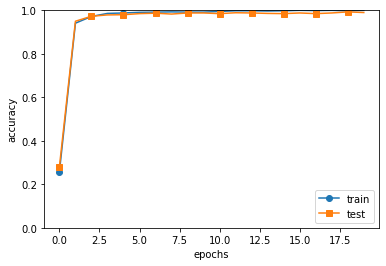

In [10]:
import matplotlib.pyplot as plt
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 7.6  CNN 시각화하기

![cnn.png](https://sean-parkk.github.io/assets/images/DLscratch/7/Untitled%2011.png)

합성 곱 계층을 여러겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출됨

### 7.7 대표적인 CNN

#### LeNet
손글씨 숫자를 인식하는 네트워크
![lenet.png](https://lh3.googleusercontent.com/proxy/VRzAs2UH2vQsxc1_tFTkRUQ7sXkgaFg1FFNqROUSFOQjQrafVOSNmvZj0_vVkeLdlOjrkGVZ_aSoNjPnCCLOt1UEgDFOaq1gsmnecggEtAkEsKE1hbk-6_UgrJ5NMR_vU7OrnVdRauJQUj2ggeq1VtDtbHkHzHcg1SYOJJ7UHMEB0g)

현재의 CNN과 비교하면 몇가지 차이가 있음
- 활성화 함수로 시그모이드를 사용한다
- LeNet은 서브샘플링을 하여 중간 데이터의 크기가 작아지지만 현재는 최대풀링이 주류이다

#### AlexNet
- 활성화함수로 ReLU를 이용한다
- LRN이라는 국소적 정규화를 실시하는 계층을 이용한다
- 드롭아웃을 사용한다

![alexnet.png](https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E)

### 7.8 정리

* CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
* 합성곱 계층과 풀링 계층은 im2col (이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.
* CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
* 대표적인 CNN에는 LeNet과 AlexNet이 있다.
* 딥러닝의 발전에는 빅 데이터와 GPU가 크게 기여했다.
